In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from threeML import *
import numpy as np
from threeML.plugins import *
from skylab.datasets import Datasets
from astropy import units as u
from imp import reload
import scipy.optimize
import mla.core
import mla.injection
import mla.spectral
import warnings
warnings.filterwarnings("ignore")

import os, sys, glob, abc

def read(filelist):
    data = []
    for f in sorted(filelist):
        x = np.load(f)
        if len(data) == 0: data = x.copy()
        else: data = np.concatenate([data, x])
    return data

# Where is the dataset stored?
dataset = "/data/i3store/users/mjlarson/student_data"

# Read in all of the data files
data_files = dataset + "/IC86_*exp.npy"
exp = read(glob.glob(data_files))

# Read in all of the MC files 
sim_files = dataset + "/IC86*MC*npy"
mc = read(glob.glob(sim_files))

# Set the angular error floor to 0.2 degrees
#exp['angErr'][exp['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)
#mc['angErr'][mc['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)

exp['ra']=np.random.uniform(0,2*np.pi,size=len(exp))
grl = np.load("/data/i3store/users/mjlarson/student_data/GRL/IC86_2012_exp.npy")
livetime = np.sum(grl['livetime'])



Bad key "text.kerning_factor" on line 4 in
/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/data/disk01/home/jasonfan/threeML/threeML/__init__.py:12: UserWarning: No DISPLAY variable set. Using backend for graphics without display (Agg)
  warnings.warn("No DISPLAY variable set. Using backend for graphics without display (Agg)")
/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/core/parameter.py:555: UserWarning: We have set the min_value of K to 1e-99 because there was a postive transform
  warnings.warn('We have set the min_value of %s to 1e-99 because there was a postive transform' % self.path)
/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/core/paramet

In [2]:
# testmla=mla.core.LLH_point_source(np.radians(83.63) ,np.radians(22.0145) , exp[:5] , mc, "PowerLaw", background = exp , \
#                               background_time_profile = (56224,56324),fit_position=True
#                                   ,file_name="testprecomputed")

In [3]:
testmla=mla.core.LLH_point_source(np.radians(83.63) ,np.radians(22.0145) , exp[:5] , mc, "PowerLaw", background = exp , \
                              background_time_profile = (56224,56324),fit_position=False
                                  ,sob_spline="testprecomputed_2dbkg.pkl")

In [4]:
sp=mla.spectral.PowerLaw(1e3 , 1e-9 , -2)
injector=mla.injection.PSinjector(sp,mc,background_time_profile = (56224,56324))
injector.set_backround(exp,grl,background_window=100)
injector.set_source_location(np.radians(83.63) ,np.radians(22.0145) )


In [5]:
test=injector.sample_nevents(10000)

In [6]:
testdata=np.load("testdata.npy")
testdata['time'] = 56225

In [7]:
len(testdata)

33967

In [8]:
testmla.update_data(testdata[testdata['run']>1000000])
#testmla.update_data(testdata)
useless=testmla.eval_llh_fit()
tempresult=testmla.get_fit_result()

sob_ratios = testmla.evaluate_interpolated_ratio()
temp=sob_ratios[:,8]

In [ ]:
sob_ratios[8]

array([21.02024312, 18.02489301,  1.15934446,  0.52089298,  1.05641525,
        2.7777113 ,  0.48109212,  0.63358091, 22.16514376,  0.48625557,
        0.51495654, 13.04021234, 11.4654162 , 23.1101519 ,  8.11128997])

In [ ]:
np.save("energymla.npy",sob_ratios[8])
np.save("temp.npy",testmla.data)

In [ ]:
sob_ratios = testmla.evaluate_interpolated_ratio()
sob_spline = np.zeros(len(testmla.data), dtype=object)
for i in range(len(testmla.data)):
    spline = scipy.interpolate.UnivariateSpline(testmla.gamma_point,
                                np.log(sob_ratios[:,i]),
                                k = 3,
                                s = 0,
                                ext = 'raise')
    sob_spline[i] = spline
def inner_ts(parameter):
    gamma = parameter[0]
    ns = parameter[1]
    e_lh_ratio = testmla.get_energy_sob(gamma, sob_spline)
    ts = ( ns/testmla.N * (e_lh_ratio*testmla.spatial*testmla.t_lh_ratio - 1))+1
    return -2*(np.sum(np.log(ts))+testmla.drop*np.log(1-ns/testmla.N))

bounds= [[testmla.gamma_point[0], testmla.gamma_point[-1]],[0,testmla.N+1]]
bf_params = scipy.optimize.minimize(inner_ts,
                    x0 = [-2,1],
                    bounds = bounds,
                    method = 'SLSQP',
                    )

In [ ]:
bf_params

     fun: -306.4708619794548
     jac: array([-11.34371567,  -1.99876785])
 message: 'Optimization terminated successfully.'
    nfev: 143
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([-2.28041777, 14.99999709])

In [ ]:

testmla.energy

array([14.94407671, 10.98408362,  1.38955547,  0.84531457,  1.29382158,
        3.03783826,  0.73009206,  0.88028711, 13.4287021 ,  0.75905608,
        0.76374132,  8.0192379 ,  8.72733809, 15.65125897,  7.56184001])

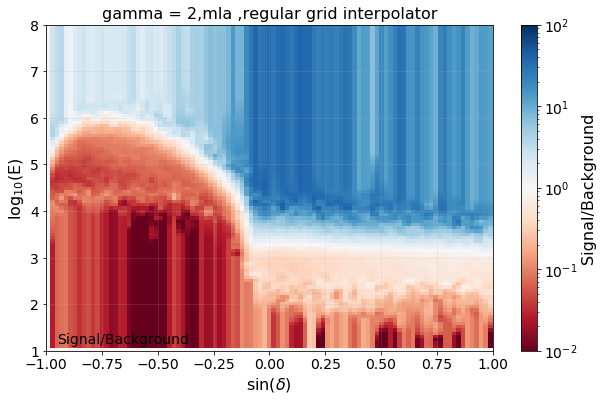

In [ ]:
from matplotlib import pyplot as plt, colors
fig, ax = plt.subplots(figsize=(10,6))
sindec=np.linspace(-1,1,100)
logE=np.linspace(1,8,100)
ratio = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        ratio[i][j] = np.exp(testmla.ratio[8]([sindec[i],logE[j]]))
cmesh = ax.pcolormesh(np.linspace(-1,1,100), np.linspace(1,8,100), ratio.T,
                     cmap = 'RdBu',
                     norm = colors.LogNorm(),
                     vmin = 1e2,
                     vmax = 1e-2)
cbar = plt.colorbar(cmesh, ax=ax)
ax.text(-0.95, 1.1, 
        "Signal/Background",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=14)
ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
ax.set_title(r"gamma = 2,mla ,regular grid interpolator", fontsize=16)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)
np.save("mla_ratio.npy",ratio.T)

In [ ]:
testmla.ratio[10]([0.3,2])

array([-2.66734719])

In [ ]:
in_ns=np.arange(5,101)
def injectns(inject_ns):
    result = []
    ns=inject_ns
    for i in range(100):
        testmla.update_data(injector.draw_data())
        testmla.modify_injection(injector.sample_nevents(ns))
        useless=testmla.eval_llh_fit()
        tempresult=testmla.get_fit_result()
        result.append((inject_ns,tempresult[0],tempresult[1],tempresult[2]))
    return np.array(result)

In [ ]:
testmla.data

array([(1102908984,  33499, 0, 1.46377465, 0.38556877, 5.37532634, 1.92585567, 56225., 4.06384797, 0.00669479, 0.00669479, 0.3760862 , 0.10990581),
       (1106902255,   3649, 0, 1.46454355, 0.38344952, 0.20298426, 1.94084779, 56225., 4.42614817, 0.00355987, 0.00355987, 0.3741217 , 0.11024075),
       (1102906787, 170002, 0, 1.46121104, 0.39108971, 0.71670658, 1.9560888 , 56225., 3.22742741, 0.00502818, 0.00502818, 0.38119608, 0.10833102),
       (1102904345, 173344, 0, 1.47891243, 0.36350115, 4.83755327, 1.97542897, 56225., 2.62269379, 0.01346608, 0.01346608, 0.3555488 , 0.1063394 ),
       (1102901469,  63936, 0, 1.46974431, 0.39074284, 4.06991327, 1.97877844, 56225., 3.19781931, 0.00570702, 0.00570702, 0.38087538, 0.10843558),
       (1102905724, 102588, 0, 1.45531105, 0.38537461, 5.79306165, 1.9608385 , 56225., 3.36515981, 0.00497046, 0.00497046, 0.3759063 , 0.10994342),
       (1102902644,  10500, 0, 1.45933375, 0.38428687, 2.05977206, 1.93455487, 56225., 2.90927771, 0.00860557, 0

In [ ]:


from multiprocessing import Pool
p=Pool(30)
allresult=p.map(injectns,in_ns)
allresult=np.array(allresult)
np.save("allresult_new.npy",allresult)
p.close()

In [ ]:
gamma_list=[]
ts_list=[]
ns_list=[]
for i in range(allresult.shape[0]):
    ns_inject=allresult[i][0][0]
    gamma=allresult[i][:,1]
    ts=(-allresult[i][:,3])
    ns=allresult[i][:,2]
    gamma_list.append(np.array([gamma.mean(),gamma.std()]))
    ts_list.append(np.array([ts.mean(),ts.std()]))
    ns_list.append(np.array([ns.mean(),ts.std()]))

    
gamma_list=np.array(gamma_list)
ts_list=np.array(ts_list)
ns_list=np.array(ns_list)

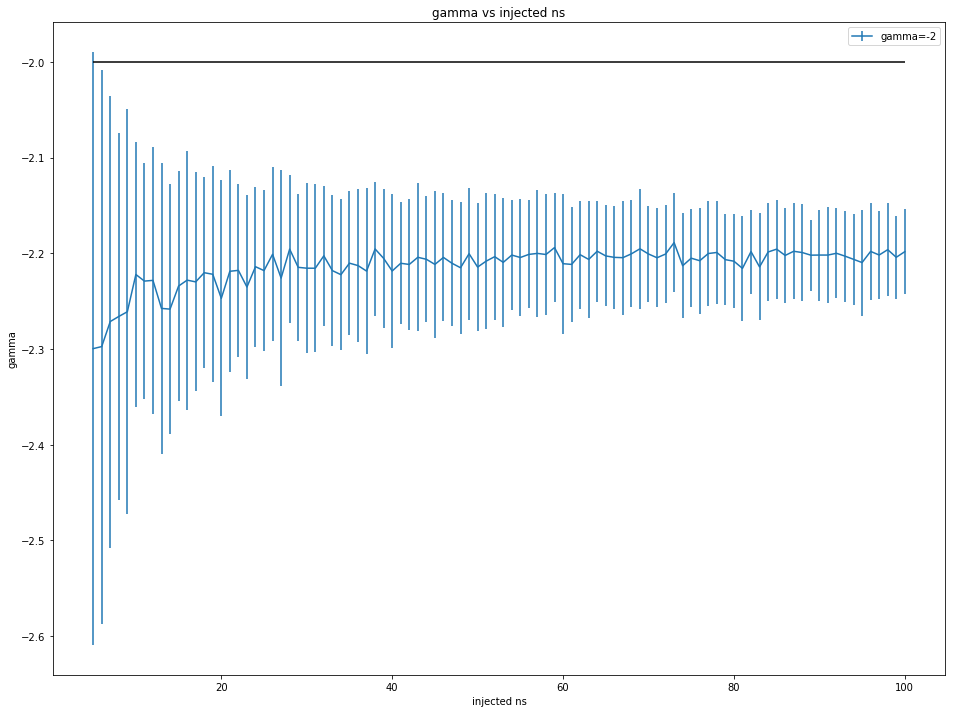

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))


ax.errorbar(in_ns, gamma_list[:,0],
            yerr=gamma_list[:,1],
            fmt='-',label="gamma=-2")


ax.hlines(-2,5,100)
ax.set_xlabel("injected ns")
ax.set_ylabel("gamma")
ax.set_title("gamma vs injected ns")
ax.legend()

In [ ]:
sp=mla.spectral.PowerLaw(1e3 , 1e-9 , -2.5)
injector=mla.injection.PSinjector(sp,mc,background_time_profile = (56224,56324))
injector.set_backround(exp,grl,background_window=100)
injector.set_source_location(np.radians(83.63) ,np.radians(22.0145) )
def injectns(inject_ns):
    result = []
    ns=inject_ns
    for i in range(100):
        testmla.update_data(injector.draw_data())
        testmla.modify_injection(injector.sample_nevents(ns))
        useless=testmla.eval_llh_fit()
        tempresult=testmla.get_fit_result()
        result.append((inject_ns,tempresult[0],tempresult[1],tempresult[2]))
    return np.array(result)
p=Pool(30)
allresult25=p.map(injectns,in_ns)
allresult25=np.array(allresult25)
np.save("allresult2.5.npy",allresult25)
p.close()


gamma_list25=[]
ts_list25=[]
ns_list25=[]
for i in range(allresult25.shape[0]):
    ns_inject=allresult25[i][0][0]
    gamma=allresult25[i][:,1]
    ts=(-allresult25[i][:,3])
    ns=allresult25[i][:,2]
    gamma_list25.append(np.array([gamma.mean(),gamma.std()]))
    ts_list25.append(np.array([ts.mean(),ts.std()]))
    ns_list25.append(np.array([ns.mean(),ts.std()]))

    
gamma_list25=np.array(gamma_list25)
ts_list25=np.array(ts_list25)
ns_list25=np.array(ns_list25)


sp=mla.spectral.PowerLaw(1e3 , 1e-9 , -3)
injector=mla.injection.PSinjector(sp,mc,background_time_profile = (56224,56324))
injector.set_backround(exp,grl,background_window=100)
injector.set_source_location(np.radians(83.63) ,np.radians(22.0145) )
def injectns(inject_ns):
    result = []
    ns=inject_ns
    for i in range(100):
        testmla.update_data(injector.draw_data())
        testmla.modify_injection(injector.sample_nevents(ns))
        useless=testmla.eval_llh_fit()
        tempresult=testmla.get_fit_result()
        result.append((inject_ns,tempresult[0],tempresult[1],tempresult[2]))
    return np.array(result)
p=Pool(30)
allresult3=p.map(injectns,in_ns)
allresult3=np.array(allresult3)
np.save("allresult3.npy",allresult3)
p.close()


gamma_list3=[]
ts_list3=[]
ns_list3=[]
for i in range(allresult3.shape[0]):
    ns_inject=allresult3[i][0][0]
    gamma=allresult3[i][:,1]
    ts=(-allresult3[i][:,3])
    ns=allresult3[i][:,2]
    gamma_list3.append(np.array([gamma.mean(),gamma.std()]))
    ts_list3.append(np.array([ts.mean(),ts.std()]))
    ns_list3.append(np.array([ns.mean(),ts.std()]))

    
gamma_list3=np.array(gamma_list3)
ts_list3=np.array(ts_list3)
ns_list3=np.array(ns_list3)


In [33]:
len(in_ns)

100

ValueError: shape mismatch: objects cannot be broadcast to a single shape

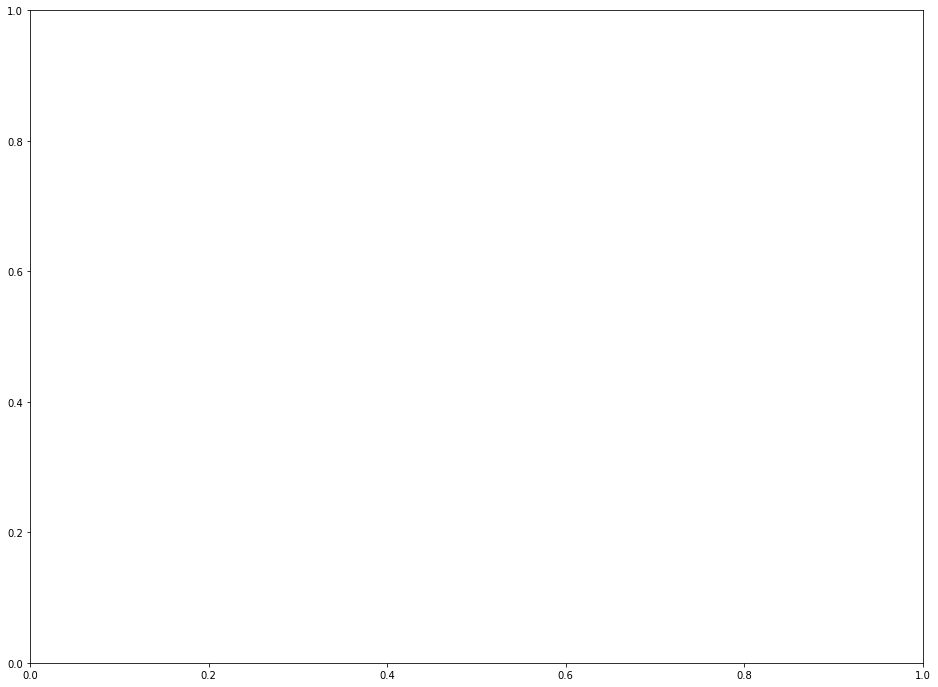

In [25]:
fig, ax = plt.subplots(figsize=(16,12))


ax.errorbar(in_ns, gamma_list[:,0],
            yerr=gamma_list[:,1],
            fmt='-',label="gamma=-2")


ax.hlines(-2,5,100)
ax.errorbar(in_ns, gamma_list25[:,0],
            yerr=gamma_list25[:,1],
            fmt='-',label="gamma=-2.5")
ax.hlines(-2.5,5,100)
ax.errorbar(in_ns, gamma_list3[:,0],
            yerr=gamma_list3[:,1],
            fmt='-',label="gamma=-3")
ax.hlines(-3,5,100)
ax.set_xlabel("injected ns")
ax.set_ylabel("gamma")
ax.set_title("gamma vs injected ns")
ax.legend()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

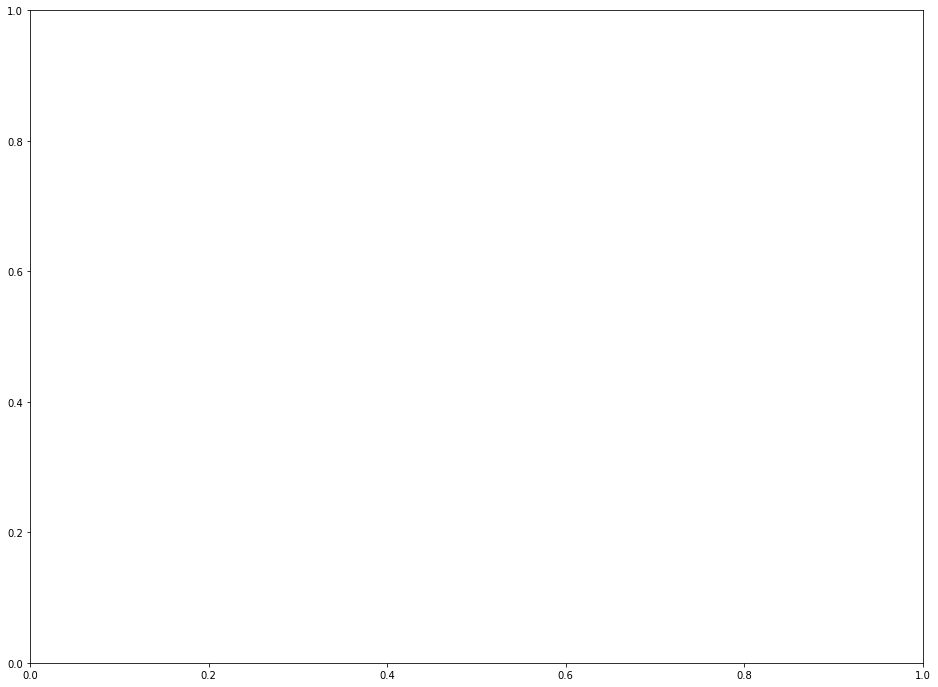

In [29]:
fig, ax = plt.subplots(figsize=(16,12))


ax.errorbar(in_ns, ns_list[:,0],
            yerr=ns_list[:,1],
            fmt='-',label="gamma=-2")
ax.errorbar(in_ns, ns_list25[:,0],
            yerr=ns_list25[:,1],
            fmt='-',label="gamma=-2.5")

ax.errorbar(in_ns, ns_list3[:,0],
            yerr=ns_list3[:,1],
            fmt='-',label="gamma=-3")
# ax.errorbar(in_ns, ns_list[:,0],
#             yerr=0,
#             fmt='-',label="gamma=-2")
# ax.errorbar(in_ns, ns_list25[:,0],
#             yerr=0,
#             fmt='-',label="gamma=-2.5")

# ax.errorbar(in_ns, ns_list3[:,0],
#             yerr=0,
#             fmt='-',label="gamma=-3")


x=np.linspace(5,100,1000)
ax.plot(x,x,label="y=x")
ax.set_xlabel("injected ns")
ax.set_ylabel("fitted ns")
ax.set_title("gamma=-2")
ax.legend(fontsize=16)

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))

in_ns = np.linspace(1,40,100)

ax.errorbar(in_ns, ns_list[:,0],
            yerr=0,
            fmt='-',label="gamma=-2")
ax.errorbar(in_ns, ns_list25[:,0],
            yerr=0,
            fmt='-',label="gamma=-2.5")

ax.errorbar(in_ns, ns_list3[:,0],
            yerr=0,
            fmt='-',label="gamma=-3")


x=np.linspace(5,100,1000)
ax.plot(x,x,label="y=x")
ax.set_xlabel("injected ns")
ax.set_ylabel("fitted ns")
ax.set_title("gamma=-2")
ax.legend(fontsize=16)